<a href="https://colab.research.google.com/github/kiasar/vgg11/blob/main/VGG11_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from tqdm import tqdm

print(torch.__version__)
print(matplotlib.__version__)
print(np.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

1.12.1+cu113
3.2.2
1.21.6
cuda


# PART 1, Traning a VGG11

In [ ]:
# Loading the dataset MNIST

n_epochs = 5
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.001


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
for samples, targets in train_loader:
  print(samples.shape)
  print(targets)
  break

torch.Size([64, 1, 32, 32])
tensor([0, 6, 5, 3, 5, 9, 0, 0, 2, 2, 8, 3, 3, 1, 6, 9, 3, 9, 6, 0, 2, 2, 6, 2,
        8, 5, 6, 4, 6, 2, 9, 2, 2, 9, 8, 2, 5, 6, 8, 1, 2, 0, 6, 3, 7, 6, 3, 6,
        4, 4, 2, 0, 6, 1, 5, 7, 6, 3, 7, 9, 6, 6, 8, 0])


In [ ]:
"""
The paper of VGG can be found at this link: https://arxiv.org/pdf/1409.1556.pdf

The input size is 32 × 32

The VGG11 architecture is as follow:
- Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
- Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
- Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
- Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
- Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
- FC(0512, 4096) - ReLU - Dropout(0.5)
- FC(4096, 4096) - ReLU - Dropout(0.5)
- FC(4096, 10)

Where:
Conv(input channels, output channels, kernel size, stride, padding)
BatchNorm(number of channels)
MaxPool(kernel size, stride)
FC(number of input, number of output) := FC is fully connected
"""

class VGG11(nn.Module):

    def __init__(self, input_channals = 1, num_out_classes = 10):
      super(VGG11, self).__init__()

      self.conv1 = nn.Conv2d(input_channals, 64 , 3, 1, 1)
      self.conv2 = nn.Conv2d(64 , 128, 3, 1, 1)
      self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
      self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
      self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
      self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
      self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
      self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)

      self.bn1 = nn.BatchNorm2d(64)
      self.bn2 = nn.BatchNorm2d(128)
      self.bn3 = nn.BatchNorm2d(256)
      self.bn4 = nn.BatchNorm2d(256)
      self.bn5 = nn.BatchNorm2d(512)
      self.bn6 = nn.BatchNorm2d(512)
      self.bn7 = nn.BatchNorm2d(512)
      self.bn8 = nn.BatchNorm2d(512)

      self.fc1 = nn.Linear(512 , 4096)
      self.fc2 = nn.Linear(4096, 4096)
      self.fc3 = nn.Linear(4096, num_out_classes)

    def forward(self, x):
        # image size should be like the papers, 32 × 32 black and white
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), (2, 2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), (2, 2))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), (2, 2))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.max_pool2d(F.relu(self.bn8(self.conv8(x))), (2, 2))

        # Flattening to feed FC, but keeping the batch dimention
        x = x.reshape(x.shape[0], -1)

        # Fully connectes
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [ ]:
net = VGG11()
print(net)

VGG11(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.4085,  0.4845, -0.2221, -0.0594,  0.2109,  0.1564, -0.5336,  0.3209,
         -0.4032,  0.1558]], grad_fn=<AddmmBackward0>)


In [ ]:
def train(model, device, train_loader, optimizer, LossF):
  model.to(device)
  model.train()
  for data, target in tqdm(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      output = model(data)
      loss = LossF(output, target)
      loss.backward()
      optimizer.step()

In [ ]:
def test(data_loader, model, device, LossF):
    model.eval()
    test_loss = 0

    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += LossF(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)
    print("Average loss: " , test_loss)
    acc = 100. * correct / len(data_loader.dataset)
    print("Accuracy: " , acc)

    return test_loss, acc

In [ ]:
testacc = []
testloss = []

trainacc = []
trainloss = []


model = VGG11().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
LossF = nn.CrossEntropyLoss()

for epoch in range(1, n_epochs + 1):
  print("========================", epoch)
  train(model, device, train_loader, optimizer, LossF)
  print(" : Train :")
  out = test(train_loader, model, device, LossF)
  trainloss.append(out[0])
  trainacc.append(out[1])
  print(" : Test :")
  out = test(test_loader, model, device, LossF)
  testloss.append(out[0])
  testacc.append(out[1])

======================== 1


100%|██████████| 938/938 [00:29<00:00, 31.79it/s]


 : Train :
Average loss:  0.002756654358020751
Accuracy:  96.255
 : Test :
Average loss:  0.002790158289554529
Accuracy:  96.55
======================== 2


100%|██████████| 938/938 [00:29<00:00, 32.07it/s]


 : Train :
Average loss:  0.001590898112017506
Accuracy:  97.755
 : Test :
Average loss:  0.0017968955718912184
Accuracy:  97.51
======================== 3


100%|██████████| 938/938 [00:29<00:00, 31.80it/s]


 : Train :
Average loss:  0.0008712613485216934
Accuracy:  98.85666666666667
 : Test :
Average loss:  0.0009397035473157302
Accuracy:  98.75
======================== 4


100%|██████████| 938/938 [00:29<00:00, 31.65it/s]


 : Train :
Average loss:  0.0008947723337478237
Accuracy:  98.64166666666667
 : Test :
Average loss:  0.0009539228088106029
Accuracy:  98.41
======================== 5


100%|██████████| 938/938 [00:29<00:00, 32.17it/s]


 : Train :
Average loss:  0.0008302130276548269
Accuracy:  98.945
 : Test :
Average loss:  0.001036687765002398
Accuracy:  98.78


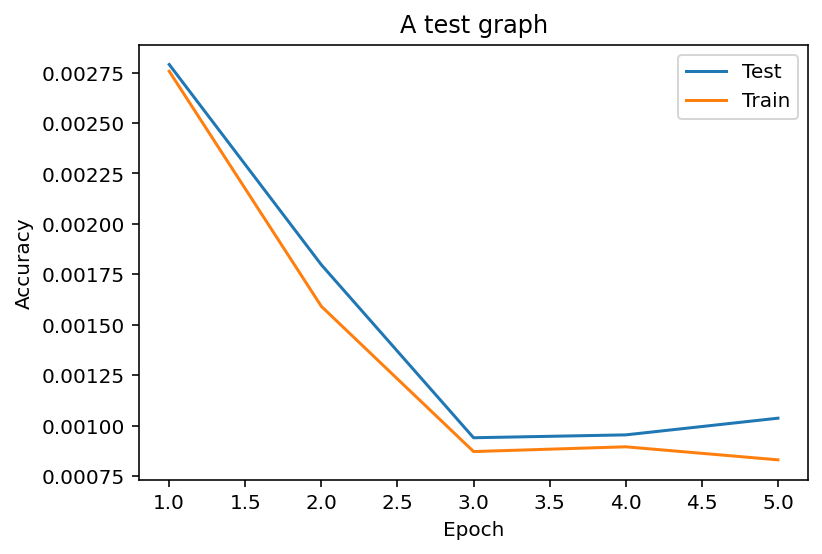

In [ ]:
x_axis = list(range(1,6))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("A test graph")
plt.plot(x_axis, testloss, label = "Test")
plt.plot(x_axis, trainloss, label = "Train")
plt.legend()
plt.show()

In [ ]:
x_axis = list(range(1,6))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("A test graph")
plt.plot(x_axis, testacc, label = "Test")
plt.plot(x_axis, trainacc, label = "Train")
plt.legend()
plt.show()

# PART 2, Data augmentation

In [ ]:
# We augment the data by flipping them horisentaly and verticaly

fliped_h_loader = torch.utils.data.DataLoader( # h means Horisental
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.RandomHorizontalFlip(p=1),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


fliped_v_loader = torch.utils.data.DataLoader( # v means Vertical
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.RandomVerticalFlip(p=1),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
print("Horisental")
test(fliped_h_loader, model, device, LossF)
print("Vertical")
test(fliped_v_loader, model, device, LossF)

# You can see accuracies are very low because the model is not trained on them

Horisental
Average loss:  0.09349049835205078
Accuracy:  42.59
Vertical
Average loss:  0.0855682447195053
Accuracy:  45.04


In [ ]:
# Another kind of data augmentation is to noise the photos.
# Higher variance means more noise

for variance in [1, 0.1, 0.01]:

  gaussian_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Lambda(lambda x : x + variance*torch.randn_like(x)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  print("variance: ", variance)
  test_dataloder(gaussian_loader, model, device, LossF)

variance:  1
Average loss:  0.05911792039871216
Accuracy:  22.76
variance:  0.1
Average loss:  0.000905209476366872
Accuracy:  98.71
variance:  0.01
Average loss:  0.000584622294255314
Accuracy:  99.14


# PAERT 3, Traning on augmented data

In [ ]:
from random import random


main_dataset =   torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


fliped_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

gussian_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Lambda(lambda x : x + (random())*torch.randn_like(x)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

fliped_gussian_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.Lambda(lambda x : x + (random())*torch.randn_like(x)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

combined_dataset = torch.utils.data.ConcatDataset([main_dataset, fliped_dataset, gussian_dataset, fliped_gussian_dataset])
# combined_dataset = torch.utils.data.ConcatDataset([main_dataset, fliped_dataset])

new_train_loader = torch.utils.data.DataLoader(combined_dataset, 
                                               batch_size=batch_size_train, 
                                               shuffle=True)

In [ ]:
model = VGG11().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
LossF = nn.CrossEntropyLoss()

for epoch in range(1, n_epochs + 1):
  print("========================", epoch)
  train(model, device, new_train_loader, optimizer, LossF)
  print(" : Test :")
  test(test_loader, model, device, LossF)

======================== 1


100%|██████████| 3750/3750 [01:56<00:00, 32.26it/s]


 : Test :
Average loss:  0.0015792955889832227
Accuracy:  97.04
======================== 2


100%|██████████| 3750/3750 [01:58<00:00, 31.62it/s]


 : Test :
Average loss:  0.0011344544085208326
Accuracy:  97.75
======================== 3


100%|██████████| 3750/3750 [01:58<00:00, 31.58it/s]


 : Test :
Average loss:  0.0007497300399525557
Accuracy:  98.61
======================== 4


100%|██████████| 3750/3750 [01:57<00:00, 31.95it/s]


 : Test :
Average loss:  0.0007833397415233776
Accuracy:  98.56
======================== 5


100%|██████████| 3750/3750 [01:58<00:00, 31.64it/s]


 : Test :
Average loss:  0.0009044416327553336
Accuracy:  98.62


In [ ]:
print("Horisental")
test_dataloder(fliped_h_loader, model, device, LossF)
print("Vertical")
test_dataloder(fliped_v_loader, model, device, LossF)

for variance in [1, 0.1, 0.01]:

  gaussian_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Lambda(lambda x : x + variance*torch.randn_like(x)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  print("variance: ", variance)
  test_dataloder(gaussian_loader, model, device, LossF)

Horisental
Average loss:  0.0017337645716965198
Accuracy:  96.81
Vertical
Average loss:  0.0018429727960843593
Accuracy:  96.48
variance:  1
Average loss:  0.008733542507886887
Accuracy:  83.34
variance:  0.1
Average loss:  0.0009706655116126058
Accuracy:  98.55
variance:  0.01
Average loss:  0.0009546523813100066
Accuracy:  98.61
